# Models of Neural Systems - Computer Practical 5
# Author: Robert Tjarko Lange

In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt

# Question 1 - Potassium Channel

In [2]:
# Setup - Define Relevant Potassium Functions
def alpha_n(V):
    # opening rate: voltage-gated transition rate in ms-1
    return (0.01*(V + 55))/(1-np.exp(-0.1*(V + 55)))

def beta_n(V):
    # closing rate: voltage-gated transition rate in ms-1
    return 0.125*np.exp(-0.0125*(V + 65))

def dn(n, t, V):
    # First-order kinetic equation - prob. of opening/closing of ion gate
    return alpha_n(V)*(1-n) - beta_n(V)*n

def I_K(g_K, n, V, E_K):
    # potassium current
    return g_K*n**4*(V - E_K)

def tau_n(V):
    # Time constant with which ss is approached
    return 1./(alpha_n(V) + beta_n(V))

def n_ss(V):
    # Steady state response - prob open
    return alpha_n(V)/(alpha_n(V) + beta_n(V))

In [3]:
# Define Euler Approximation Function with special Voltage clamp case
def euler(f_func, x0, t_max, dt, V_c, type="standard"):
    time = np.arange(0, t_max+dt, dt) # array with all time points
    nstep = time.size # number of time steps to be computed
    x = np.zeros(nstep) # initialize array to store all x(t) values, same size as time
    x[0] = x0 # fill in initial value

    for i in range(nstep-1): # loop over time STEPS
        if type == "voltage-clamp":
            if time[i] < 2:
                # add check for voltage clamp conditions
                V_temp = -65
            else:
                V_temp = V_c
        else:
            V_temp = V_c
        x[i+1] = x[i] + f_func(x[i], time[i], V_temp)*dt #euler integration
    return time, x

In [4]:
def potassium_voltage_clamp_current_euler(max_T, dt, V_c_s=[-80, -60, -50, -40]):
    E_K = -77 # in mV Reversal potential potassium
    g_K = 36  # in nS maximum conductance

    n_0 = 0.3177
    I_K_results = []
    inst_K_I = []
    ss_K_I = []

    for V_c in V_c_s:
        n_ss_temp = n_ss(V_c)

        time, n_K = euler(dn, n_0, max_T, dt, V_c, type="voltage-clamp")
        I_K_V_c = I_K(g_K, n_K, V_c, E_K)

        I_K_results.append(I_K_V_c)

        inst_K_I.append(I_K_V_c[int(np.argwhere(time == 2))])
        ss_K_I.append(I_K_V_c[np.argwhere(np.absolute(n_K - n_ss_temp) < 0.01)[0]])

    return time, I_K_results, inst_K_I, ss_K_I

In [5]:
# Define Plot Helpers
def plot_time_activation_potassium(V_s, tau_n_eval, n_ss_eval, n_K_euler):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 12))
    fig.tight_layout()

    ax[0].plot(V_s, tau_n_eval)
    ax[1].plot(V_s, n_ss_eval, alpha=0.5, label="Analytical")
    ax[1].plot(V_s, n_K_euler, alpha=0.5, label="Euler Approximation")

    ax[1].set_xlabel("Voltage V (mV)")
    ax[0].set_ylabel(r"$\tau_m(V)$ (mSec)")
    ax[1].set_ylabel(r"$n_\infty(V)$ ($ms^{-1}$)")

    ax[0].set_title("Activation Time Constant")
    ax[1].set_title("Steady State Response")
    plt.legend()
    plt.show()

def plot_n_K_approx(time, n_K):
    plt.plot(time, n_K)
    plt.title(r"Sanity Check of $n_K$ Euler Approximation")
    plt.axhline(0.69, alpha=0.5, c="black", linestyle="--")
    plt.axhline(0.68, alpha=0.5, c="red", linestyle="--")
    plt.axhline(0.7, alpha=0.5, c="red", linestyle="--")
    plt.xlabel(r"Time (in mSec)")
    plt.ylabel(r"$n_K$ ($ms^{-1}$)")
    plt.show()
    
def plot_voltage_clamp_current(time, I_results,
                               title=r"Current Responses $I_K$ under Voltage Clamp Conditions",
                               labels = [r"$V_c = -80$", r"$V_c = -60$",
                                         r"$V_c = -50$", r"$V_c = -40$"]):
    for i, I_temp in enumerate(I_results):
        plt.plot(time, I_temp, label=labels[i])
    plt.xlabel("Time (mSec)")
    plt.ylabel(r"$I$")
    plt.legend()
    plt.title(title)
    plt.show()

def plot_current_voltage_relation(V_c_s, inst_K_current, ss_K_current, title="Potassium Channel: Current-Voltage (I-V) Relation"):
    plt.title(title)
    plt.plot(V_c_s, inst_K_current, label=r"Instantaneous")
    plt.plot(V_c_s, ss_K_current, label="Steady-State")
    plt.xlabel(r"Voltage $V_c$")
    plt.ylabel(r"Current $I_K$")
    plt.legend()
    plt.show()

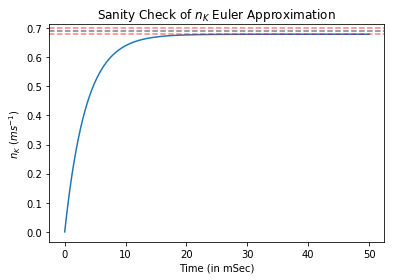

In [6]:
# Q1b - Check approximation correctness
time, n_K = euler(dn, 0, 50, 0.01, -40)
plot_n_K_approx(time, n_K)

/Users/rtl/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide
/Users/rtl/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in double_scalars


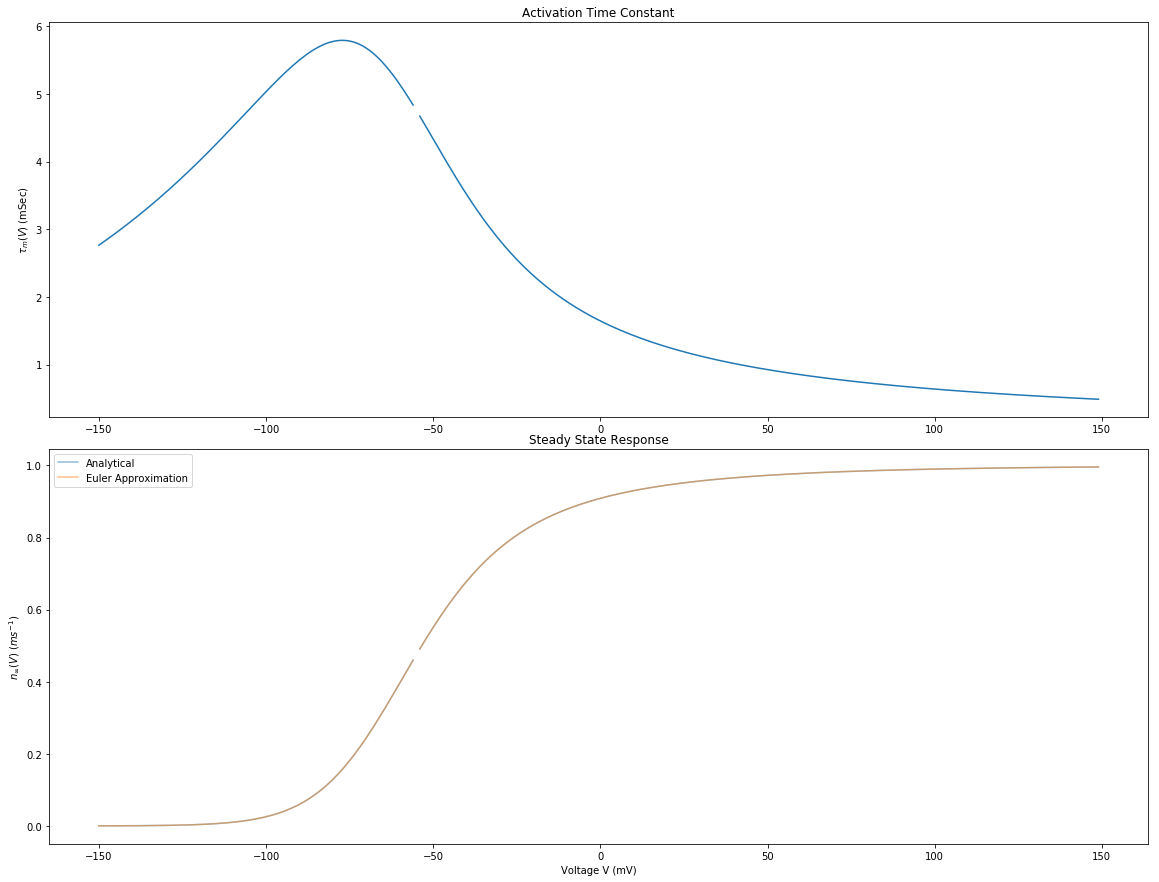

In [7]:
# Q1b - Compute responses/waiting time for diffferent membrane potentials
V_s = np.arange(-150, 150, 1)
tau_n_eval = tau_n(V_s)
n_ss_eval = n_ss(V_s)

n_K_euler = []
for V_temp in V_s:
    time, n_K = euler(dn, 0, 50, 0.01, V_temp)
    n_K_euler.append(n_K[-1])

plot_time_activation_potassium(V_s, tau_n_eval, n_ss_eval, n_K_euler)

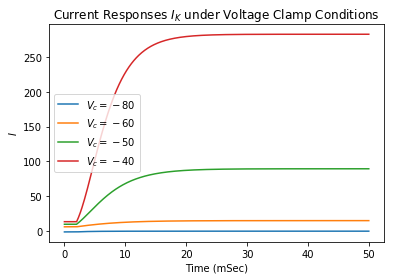

In [8]:
# Q1c - Compute current responses to different voltage commands in voltage clamp
time, I_K_results, inst_K_current, ss_K_current = potassium_voltage_clamp_current_euler(50, 0.1)
plot_voltage_clamp_current(time, I_K_results)

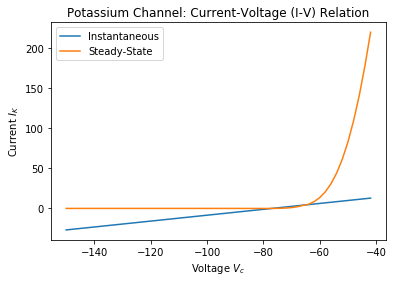

In [9]:
# Q1d - Potassium Channel: Current-Voltage Relation
V_c_s = np.arange(-150, -40, 2).tolist()
time, I_K_results, inst_K_current, ss_K_current = potassium_voltage_clamp_current_euler(200, 0.1, V_c_s)
plot_current_voltage_relation(V_c_s, inst_K_current, ss_K_current)

### Observations: Persistent Response of Potassium Channel
* Description of results: Command voltage has significant effect on current responses. The larger (less negative) the command voltage, the stronger the current response.

* Predicted effect of potassium current on membrane potential: Depolarization and action potential elicitation.

* Results with respect to $n_\infty$: As the command voltage increases the probability of the channel opening goes to 1.

* Results with respect to $\tau_\infty$: As the command voltage increases the waiting time/time scale with which the steady state is approached decreases exponentially.

# Question 2 - Sodium Channel

In [10]:
def alpha_m(V):
    # Actication gate opening rate: voltage-gated transition rate in ms-1
    return (0.01*(V + 40))/(1-np.exp(-0.1*(V + 40)))

def alpha_h(V):
    # Inactivation gate opening rate: voltage-gated transition rate in ms-1
    return 0.07*np.exp(-0.05*(V + 65))

def beta_m(V):
    # Actication gate closing rate: voltage-gated transition rate in ms-1
    return 4*np.exp(-0.0556*(V + 65))

def beta_h(V):
    # Inactivation gate closing rate: voltage-gated transition rate in ms-1
    return 1./(1 + np.exp(-0.1*(V + 35)))

def dm(m, t, V):
    # First-order kinetic equation - prob. of opening/closing of activation gate
    return alpha_m(V)*(1-m) - beta_m(V)*m

def dh(h, t, V):
    # First-order kinetic equation - prob. of opening/closing of inactivation gate
    return alpha_h(V)*(1-h) - beta_h(V)*h

def I_Na(g_Na, m, h, V, E_Na):
    # Sodium Current
    return g_Na*m**3*h*(V-E_Na)

def m_ss(V):
    # Steady state response
    return alpha_m(V)/(alpha_m(V) + beta_m(V))

def h_ss(V):
    # Steady state response
    return alpha_h(V)/(alpha_h(V) + beta_h(V))

def tau_m(V):
    # Time constant
    return 1./(alpha_m(V) + beta_m(V))

def tau_h(V):
    # Time constant
    return 1./(alpha_h(V) + beta_h(V))

In [11]:
def sodium_voltage_clamp_current_euler(max_T, dt, V_c_s=[-80, -60, -50, -40], sim_type="voltage-clamp"):
    E_Na = 50 # in mV Reversal potential sodium
    g_Na = 120  # in nS maximum conductance sodium channel

    m_0 = 0.0529
    h_0 = 0.5961

    I_Na_results = []
    inst_Na_I = []
    ss_Na_I = []

    for V_c in V_c_s:
        time, m_Na = euler(dm, m_0, max_T, dt, V_c, sim_type)
        time, h_Na = euler(dh, h_0, max_T, dt, V_c, sim_type)
        I_Na_V = I_Na(g_Na, m_Na, h_Na, V_c, E_Na)
        I_Na_results.append(I_Na_V)

        m_ss_temp = m_ss(V_c)
        h_ss_temp = h_ss(V_c)

        inst_Na_I.append(I_Na_V[int(np.argwhere(time == 2))])

        idx_m = np.argwhere(np.absolute(m_Na - m_ss_temp) < 0.01).ravel()
        idx_h = np.argwhere(np.absolute(h_Na - h_ss_temp) < 0.01).ravel()

        ss_Na_I.append(I_Na_V[np.intersect1d(idx_m, idx_h)[0]])

    return time, I_Na_results, inst_Na_I, ss_Na_I

In [12]:
def plot_time_activation_sodium(V_s, tau_m_eval, tau_h_eval,
                                m_ss_eval, h_ss_eval):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 12))
    fig.tight_layout()

    ax[0].plot(V_s, m_ss_eval, label=r"$m_\infty$")
    ax[0].plot(V_s, h_ss_eval, label=r"$h_\infty$")

    ax[1].plot(V_s, tau_m_eval, label=r"$\tau_m$")
    ax[1].plot(V_s, tau_h_eval, label=r"$\tau_h$")

    ax[1].set_xlabel("Voltage V (mV)")
    ax[0].set_ylabel(r"$m$; $h$")
    ax[1].set_ylabel(r"$\tau$ (mSec)")

    ax[0].set_title("Steady State Response")
    ax[1].set_title("Activation Time Constant")
    ax[0].legend()
    ax[1].legend()
    plt.show()

/Users/rtl/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


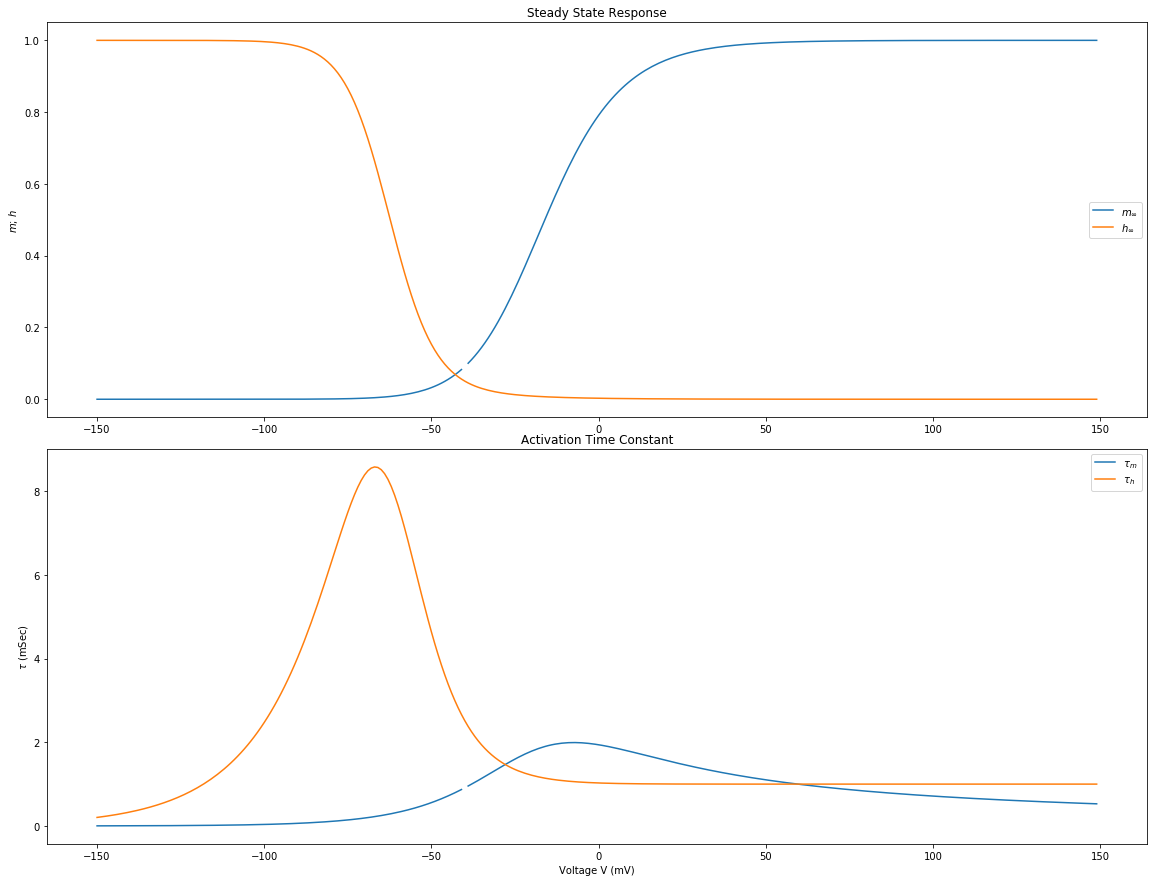

In [13]:
V_s = np.arange(-150, 150, 1)
tau_m_eval = tau_m(V_s)
tau_h_eval = tau_h(V_s)
m_ss_eval = m_ss(V_s)
h_ss_eval = h_ss(V_s)

plot_time_activation_sodium(V_s,
                            tau_m_eval, tau_h_eval,
                            m_ss_eval, h_ss_eval)

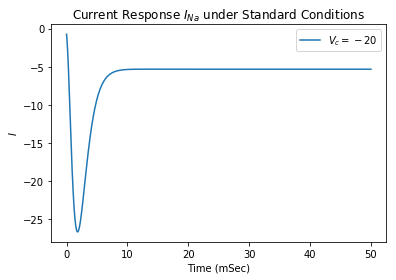

In [14]:
# Q2b - Sodium Current Responses under Standard Conditions with V_c = 20
time, I_Na_results, inst_Na_I, ss_Na_I = sodium_voltage_clamp_current_euler(50, 0.01, V_c_s=[-20], sim_type="standard")
plot_voltage_clamp_current(time, I_Na_results,
                           title=r"Current Response $I_{Na}$ under Standard Conditions",
                           labels = [r"$V_c = -20$"])

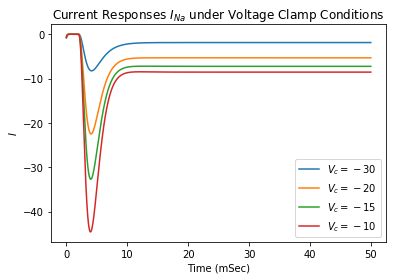

In [15]:
# Q2c - Sodium Current Responses under Voltage Clamp Conditions
time, I_Na_results, inst_Na_I, ss_Na_I = sodium_voltage_clamp_current_euler(50, 0.01, V_c_s=[-30, -20, -15, -10])
plot_voltage_clamp_current(time, I_Na_results,
                           title=r"Current Responses $I_{Na}$ under Voltage Clamp Conditions",
                           labels = [r"$V_c = -30$", r"$V_c = -20$",
                                     r"$V_c = -15$", r"$V_c = -10$"])

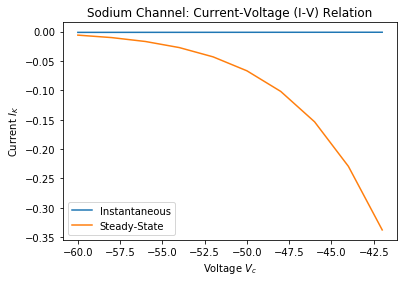

In [16]:
# Q2d - Sodium Channel: Current-Voltage Relation 
V_c_s = np.arange(-60, -40, 2).tolist()
time, I_Na_results, inst_Na_current, ss_Na_current = sodium_voltage_clamp_current_euler(200, 0.1, V_c_s)
plot_current_voltage_relation(V_c_s, inst_Na_current, ss_Na_current, title="Sodium Channel: Current-Voltage (I-V) Relation")

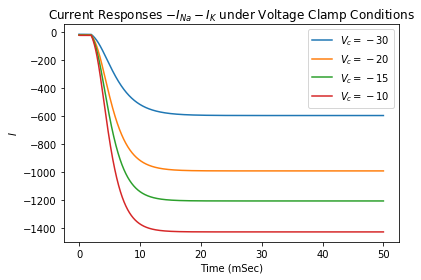

In [17]:
# Q2e - Negative Sum of Both Currents
time, I_Na_results, inst_Na_I, ss_Na_I = sodium_voltage_clamp_current_euler(50, 0.01, V_c_s=[-30, -20, -15, -10])
time, I_K_results, inst_K_I, ss_K_I = potassium_voltage_clamp_current_euler(50, 0.01, V_c_s=[-30, -20, -15, -10])

neg_sum_currents = []

for i in range(len(I_Na_results)):
    I_Na_temp = np.array(I_Na_results[i])
    I_K_temp = np.array(I_K_results[i])
    
    neg_sum_currents.append(-I_Na_temp - I_K_temp)
    
plot_voltage_clamp_current(time, neg_sum_currents,
                           title=r"Current Responses $-I_{Na}-I_K$ under Voltage Clamp Conditions",
                           labels = [r"$V_c = -30$", r"$V_c = -20$",
                                     r"$V_c = -15$", r"$V_c = -10$"])

### Observations:
* Comparison $m_\infty, h_\infty, n_\infty$: In the potassium channel case we only model 4 activation gates ($n^4$) which leads to the persistent potassium current. In the sodium channel, on the other hand, we model both 3 activation ($m^3$) and a single inactivation gate ($h$). This ultimately leads to the transient sodium current response as seen in the plots.

* Comparison $\tau_m, \tau_h, \tau_n$: The time scale with which the steady state with which the gate opening probability is approached varies for the two channels. In the potassium case it decreases as $V$ (and $n$ increase) - again this leads to the persistent behavior. For the sodium channel, on the other hand, the trade-off dynamics between $\tau_m$ and $\tau_h$ are more complicated. Both first increase and then decrease. $\tau_m$ (activation) lags behind $\tau_h$. At around -30 and +60 mV both align.

* Mechanisms of sodium current rise/decay: In the beginning of the simulation the 3 activation channels dominate the single inactivation channel. Later on the inactivation channel cancels the activation channels.

* Discussion I/V curves sodium/potassium channels: The I-V curve for the potassium channels behaves inversely to the sodium channel I-V curve. This can resemble the depolarization/hyperpolarization behavior during an action potential.